In [3]:
import numpy as np
import nlfe2d as nlfe

%matplotlib inline
import matplotlib.pyplot as plt
from beef.newmark import factors as newmark_factors
# from jupyterthemes import jtplot

# currently installed theme will be used to
# set plot style if no arguments provided
# jtplot.style(theme='default', gridlines='--', figsize=(8, 6), context='talk', fscale=1.25)

## Defining system (parts, constraints, etc.)

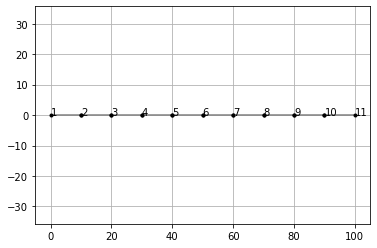

In [4]:
properties = nlfe.SectionProperties(E=210e6, A=1, I=2, m=10)
els = 10
L = 100
mid = int(els/2)

node_labels = np.arange(1,els+2)
x = (node_labels-1)/(els)*L
y = np.hstack([x[:mid]*0.1, x[mid]*0.1-(x[mid:]-x[mid])*0.1])*0
node_matrix = np.vstack([node_labels.T, x.T, y.T]).T
element_matrix = np.vstack([np.arange(1,els+1), node_labels[0:-1], node_labels[1:]]).T

constraints = [nlfe.Constraint([node_labels[0], node_labels[-1]], dofs='trans')]
part = nlfe.Part(node_matrix, element_matrix, properties, constraints)
a = part.plot(plot_nodes=True, node_labels=True) #plot part for reference
_ = a.axis('equal')
a.grid('on')

## Defining force

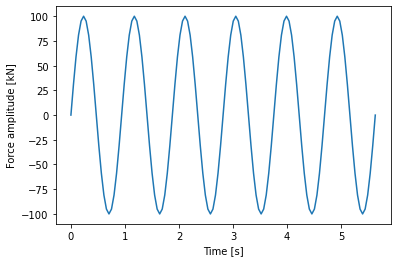

In [5]:
w_an = (np.pi/L)**2*np.sqrt(properties.E * properties.I/(properties.m/properties.A))
l = np.linalg.eigvals(np.linalg.inv(part.L.T @ part.m @ part.L) @ (part.L.T @ part.k @ part.L))
w = np.min(np.sqrt(l))*1.05

dt = 2*np.pi/w/20
tmax =  2*np.pi/w*6
t = np.arange(0, tmax+dt, dt)

A = 1e5
f_amplitude = np.sin(w*t)*A


plt.plot(t,f_amplitude/1e3)
plt.xlabel('Time [s]')
plt.ylabel('Force amplitude [kN]')


forces = [nlfe.Force(f_amplitude, [mid+1], 1, t=t)]
prescribed_displacements = [nlfe.PrescribedDisplacement(np.sin(w*t), [mid+1], 1, t=t)]

## Defining and running analyses

In [7]:
tol = dict(r=0.01)

analysis_dynamic = nlfe.Analysis(part, prescribed_displacements=prescribed_displacements, tmax=tmax, dt=dt, itmax=10, tol=tol, rayleigh={'stiffness': 1e-3, 'mass': 1e-3}, newmark_factors=newmark_factors('constant'))
analysis_lin_dynamic = nlfe.Analysis(part, forces=forces, tmax=tmax, dt=dt, rayleigh={'stiffness': 1e-3, 'mass': 1e-3}, newmark_factors=newmark_factors('constant'))
analysis_static = nlfe.Analysis(part, forces=forces, tmax=tmax, dt=dt, itmax=10, tol=tol)
# constraints = print(analysis_dynamic.part.unconstrained_dofs)

analysis_lin_dynamic.run_lin_dynamic(solver='lin_alt')
analysis_dynamic.run_dynamic()
analysis_static.run_static()

## Establish moments and shear distributions (use last time step currently)

In [8]:
moments = np.array([(el.q[2]-el.q[2+3]) for el in analysis_static.part.elements])
shear1 = np.array([el.q[1] for el in analysis_static.part.elements])
shear2 = np.array([el.q[1+3] for el in analysis_static.part.elements])
shear = np.zeros([len(shear1)+1])
shear[0] = shear1[0]
shear[-1] = -shear2[-1]
shear[1:-1] = (shear1[1:]-shear2[:-1])/2

Text(0.5, 0, 'Position [m]')

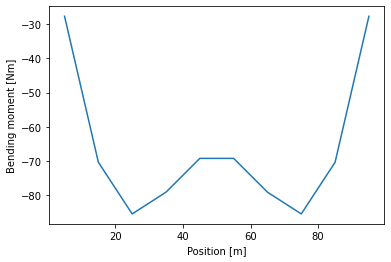

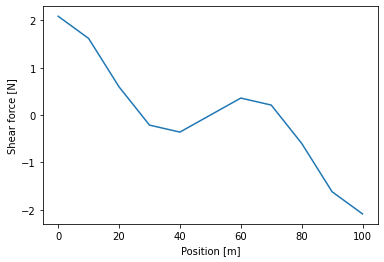

In [9]:
x_cog = [el.get_cog()[0] for el in part.elements]
plt.figure()
plt.plot(x_cog, moments)
plt.ylabel('Bending moment [Nm]')
plt.xlabel('Position [m]')
plt.figure()
plt.plot(x, shear)
plt.ylabel('Shear force [N]')
plt.xlabel('Position [m]')

## Displacements of center node: static vs. dynamic

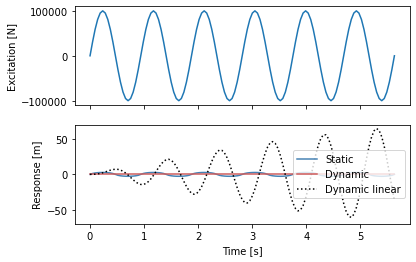

In [10]:
plt.figure(2).clf()
fig, ax = plt.subplots(ncols=1, nrows=2, num=2, sharex='all')
dof = nlfe.gdof_from_nodedof(mid, 1, n_dofs=3)

ax[0].plot(t, f_amplitude)
ax[1].plot(t, analysis_static.u[dof, :].T, label='Static', color='SteelBlue')
ax[1].plot(t, analysis_dynamic.u[dof, :].T, label='Dynamic', color='IndianRed')
ax[1].plot(t, analysis_lin_dynamic.u[dof, :].T, label='Dynamic linear', color='Black', linestyle=':')

# ax[1].set_xlim([0,1])
ax[1].set_ylim([-70,70])
ax[1].set_xlabel('Time [s]')
ax[1].set_ylabel('Response [m]')
ax[0].set_ylabel('Excitation [N]')
ax[1].legend()